In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import json
from skimage.transform import rescale

import os
os.environ["ESMFMKFILE"] = '/home/max/anaconda3/envs/crai/lib/esmf.mk'

from climatereconstructionai import config as cfg
from climatereconstructionai import train, evaluate


In [4]:
train_arg_file = '/home/max/repos/climatereconstructionAI/exaocean/sr_test.inp'
cfg.set_train_args(train_arg_file)

# list all training files
train_dir = os.path.join(cfg.data_root_dir,'train')
print('training_files: {}'.format(os.listdir(train_dir)))

#list all masks
mask_dir = cfg.mask_dir
print('masks: {}'.format((cfg.mask_names)))

# list all test files
test_dir = os.path.join(cfg.data_root_dir,'test')
print('test_files: {}'.format(os.listdir(test_dir)))

training_files: ['20cr-1ens.nc']
masks: ['hadcrut_missmask_1.nc']
test_files: ['tas_hadcrut_187709_189308.nc']


In [5]:
train_file = os.path.join(train_dir,os.listdir(train_dir)[0])
ds_train = nc.Dataset(train_file)

train_file_mask = os.path.join(cfg.data_root_dir,cfg.mask_names[0])
ds_train_mask = nc.Dataset(train_file_mask)

test_file = os.path.join(test_dir,os.listdir(test_dir)[0])
ds_test = nc.Dataset(test_file)


In [6]:
def plot_netcd_file(ds, variable='tas', max_timestemps=5, max_levels=3):

    if 'lev' in ds.variables.keys():
        n_levels_file = ds['lev'].shape[0]
        n_levels = np.min([n_levels_file, max_levels])
    else:
        n_levels_file = 1
        n_levels = 1

    if 'time' in ds.variables.keys():
        n_ts_file = ds['time'].shape[0]
        n_ts = np.min([n_ts_file, max_timestemps])     
    else:
        n_ts_file = 1
        n_ts = 1


    fig, axs = plt.subplots(n_levels, n_ts, figsize=(15,5))

    k_ts = ()
    for ts in range(n_ts):
        if n_ts > 1:
            k_ts = (ts,)
        for level in range(n_levels):
            if n_levels>1:
                k = (level,) + k_ts
            else:
                k = k_ts
            
            if (n_levels > 1) | (n_ts > 1):
                axs[k].matshow(ds[variable][k])
                axs[k].set_title('level={}, timestep={}'.format(level, ts))
            else:
                axs.matshow(ds[variable][0])
                axs.set_title('level={}, timestep={}'.format(0, 0))

    fig.suptitle('n_levels={}, n_timesteps={}'. format(n_levels_file,n_ts_file))

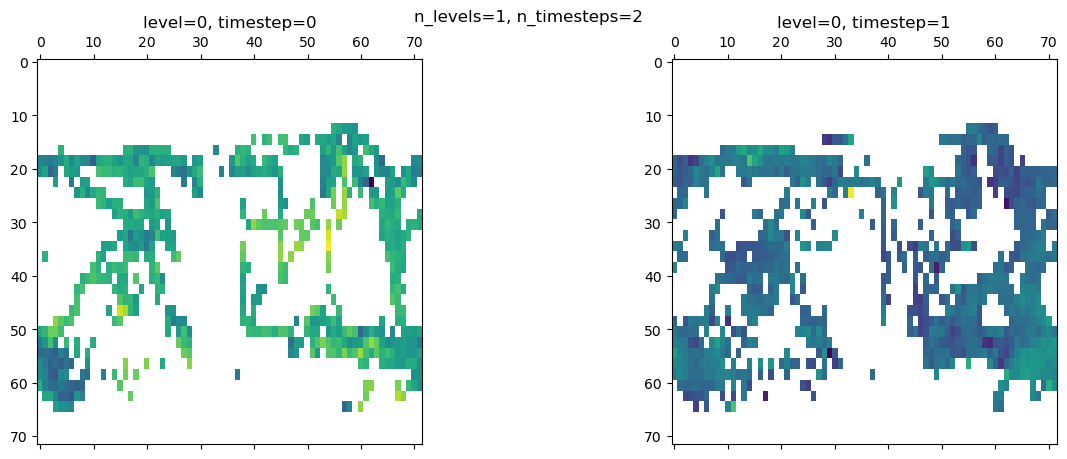

In [7]:
plot_netcd_file(ds_test, variable='tas')

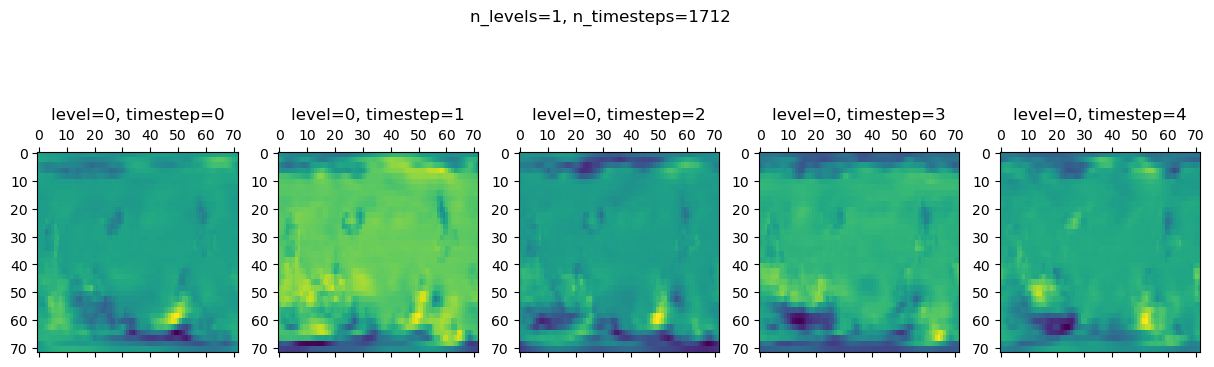

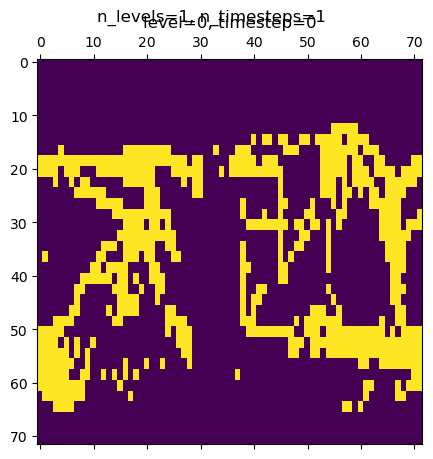

In [8]:
plot_netcd_file(ds_train, variable='tas',max_timestemps=5)

plot_netcd_file(ds_train_mask, variable='tas',max_timestemps=5)

In [129]:
ds_train_mask.variables.keys()

ds_train_mask['tas'].shape

(1, 72, 72)

In [9]:
import json

In [10]:
config_dict = {}

config_dict['device']='cpu'
config_dict['batch_size']=2
config_dict['data-root-dir']='/home/max/data/cmip6_vo_sample_remap/'
config_dict['log-dir']= 'exaocean/out/training/logs/'
config_dict['snapshot-dir']= 'exaocean/out/training/'
config_dict['data-names']= '20cr-1ens.nc'




{'device': 'cpu',
 'batch_size': 2,
 'data-root-dir': '/home/max/data/cmip6_vo_sample_remap/',
 'log-dir': 'exaocean/out/training/logs/',
 'snapshot-dir': 'exaocean/out/training/',
 'data-names': '20cr-1ens.nc'}

In [15]:
with open("test_cfg.json", "w") as outfile:
    json.dump(config_dict, outfile)

In [16]:
import argparse

In [17]:
parser = argparse.ArgumentParser()

In [ ]:


--device cpu 
--batch-size 2
--data-root-dir /home/max/data/cmip6_vo_sample_remap/
--log-dir exaocean/out/training/logs/
--snapshot-dir exaocean/out/training/
--data-names 20cr-1ens.nc
--val-names 
--max-iter 10
--save-model-interval 5
--loss-criterion 0
--eval-timesteps 0,1,2
--weights kaiming
--loop-random-seed 3
--cuda-random-seed 3
--deterministic
--shuffle-masks


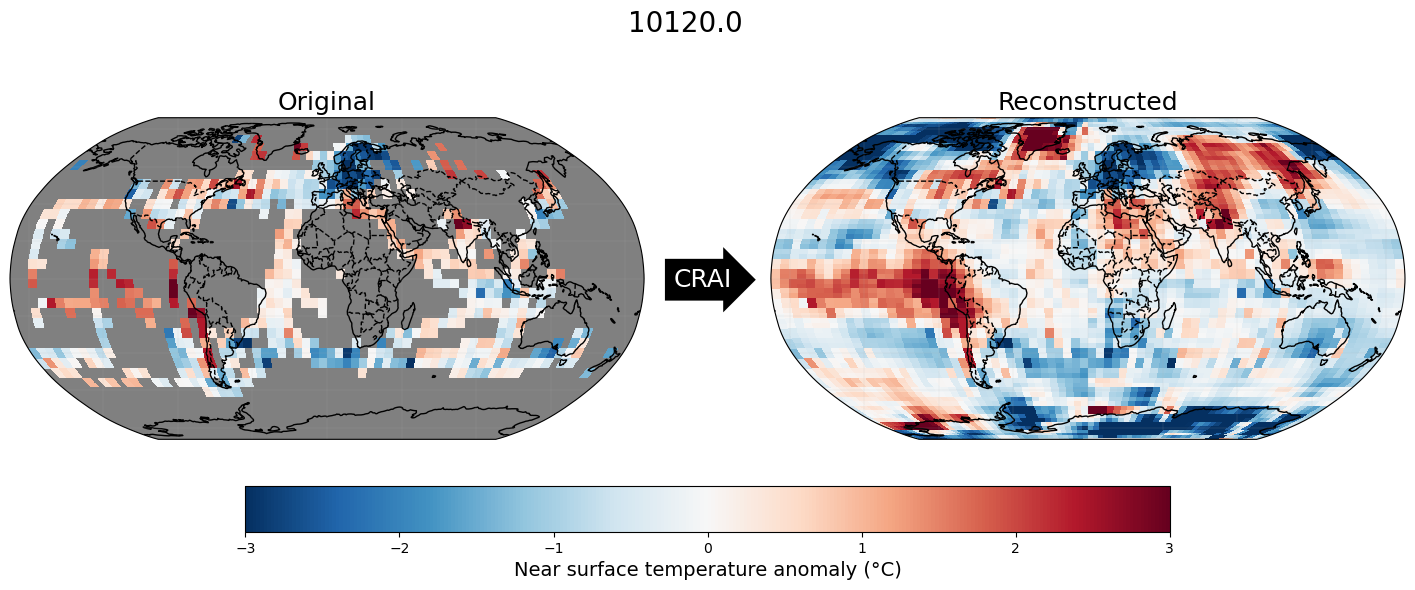

In [15]:
evaluate('demo/demo_args_jupyter.txt')

# Data Preparation

In [8]:
def modify_dataset(ds, var, settings={}):

   keep_timesteps = None if 'keep_timesteps' not in settings.keys() else settings['keep_timesteps']
   keep_levels = None if 'keep_levels' not in settings.keys() else settings['keep_levels']
   timestep_range = None if 'timestep_range' not in settings.keys() else settings['timestep_range']
   lat_range = [] if 'lat_range' not in settings.keys() else settings['lat_range']
   lon_range = [] if 'lon_range' not in settings.keys() else settings['lon_range']
   level_range = [] if 'lon_range' not in settings.keys() else settings['lon_range']

   ds_var = ds[var]

   if len(timestep_range)==0:
      if keep_timesteps is None:
         timestep_range = [0, ds_var.shape[0]]
      else:
         timestep_range = [0, keep_timesteps]
      
   if len(level_range)==0:
      if keep_levels is None:
         level_range = [0, ds_var.shape[1]]
      else:
         level_range = [0, keep_levels]

   if len(lat_range)==0:
      lat_range = [0, ds_var.shape[2]]
    
   if len(lon_range)==0:
      lon_range = [0, ds_var.shape[3]]

   ds_var = ds_var[
      timestep_range[0]:timestep_range[1],
      level_range[0]:level_range[1],
      lat_range[0]:lat_range[1],
      lon_range[0]:lon_range[1]
   ].squeeze()

   return ds_var.to_dataset()


def split_dataset(ds, var, train_frac=0.8):
   #use last timesteps for validation
   train_fraction = 0.8
   val_fraction = 1-train_fraction

   ds_var = ds[var]

   len_train = int(train_frac*ds_var.shape[0])
   ds_train = ds_var[:len_train]
   ds_val = ds_var[len_train:]

   return ds_train.to_dataset(), ds_val.to_dataset()


def prepare_dataset_upsampling(root_dir_fine: str, root_dir_coarse: str, working_dir: str, ds_name_run: str, settings={}, save_configs=True)->None:
   """function to copy and prepare dataset to the directory where the model is trained/tested

   Args:
      root_dir_fine (str): defines the root directory of the high-resolution files
      root_dir_coarse (str): defines the root directory of the low-resolution files
      working_dir (str): working directory
      ds_name_run (str): name of the dataset (-run)
      settings (dict): settings for dataset modification (cropping & removing dimensions)
         settings = {
               'lon_range': [],
               'lat_range': [],
               'level_range': [],
               'timestep_range': [],
               'keep_levels': None,
               'keep_timesteps': None,
               'split_fraction_train': 0.8,
               'merge_multiple_files': True,
               }
      save_configs(bool): if true, inputs of this functions are stored in the run_dir (working_dir/ds_name_run) are stored as json
   """

   run_dir = os.path.join(working_dir, ds_name_run)
   train_dir = os.path.join(run_dir, 'train')
   test_dir = os.path.join(run_dir, 'test')
   val_dir = os.path.join(run_dir, 'val')

   #target files (fine) are stored in the train dir
   #target_dir = os.path.join(run_dir, 'target')

   paths_to_create = [run_dir, train_dir, test_dir, val_dir]

   # create folder ins working dir
   success = [os.mkdir(path) for path in paths_to_create if not os.path.isdir(path)]

   if save_configs:
      configs = {
         'root_dir_fine':root_dir_fine,
         'root_dir_coarse':root_dir_coarse,
         'working_dir':working_dir,
         'ds_name_run':ds_name_run,
         'settings':settings
      }
      with open(os.path.join(working_dir,ds_name_run,'config.json'), "w") as f:
         json.dump(configs, f)

   files_fine = glob.glob(root_dir_fine + '/*.nc')
   files_coarse = glob.glob(root_dir_coarse + '/*.nc')

   assert len(files_coarse)==len(files_fine), 'the number of files (coarse and fine grid) is not the same'


   # set default values of settings
   merge_multiple_files = True if 'merge_multiple_files' not in settings.keys() else settings['merge_multiple_files']
   train_frac = 0.8 if 'train_frac' not in settings.keys() else settings['train_frac']

   if merge_multiple_files:
      run_file_path_train = os.path.join(train_dir,os.path.basename(os.path.commonpath(files_coarse))+'.nc')
      run_file_path_val = os.path.join(val_dir,os.path.basename(os.path.commonpath(files_coarse))+'.nc')
      run_file_path_train_t = os.path.join(train_dir,os.path.basename(os.path.commonpath(files_coarse))+'_t.nc')
      run_file_path_val_t = os.path.join(val_dir,os.path.basename(os.path.commonpath(files_coarse))+'_t.nc')


      ds_fine = xr.open_mfdataset(files_fine)
      new_ds = modify_dataset(ds_fine, 'vo', settings=settings)
      new_ds_train, new_ds_val = split_dataset(new_ds, 'vo', train_frac=train_frac)
      new_ds_train.to_netcdf(run_file_path_train_t)
      new_ds_val.to_netcdf(run_file_path_val_t)

      ds_coarse = xr.open_mfdataset(files_coarse)
      new_ds = modify_dataset(ds_coarse, 'vo', settings=settings)
      new_ds_train, new_ds_val = split_dataset(new_ds, 'vo', train_frac=train_frac)
      new_ds_train.to_netcdf(run_file_path_train)
      new_ds_val.to_netcdf(run_file_path_val)
   #else:
   #    for file in files_coarse:
   #        ds = xr.open_dataset(file)
   #        run_file_path_train = os.path.join(train_dir,'train',os.path.basename(file))
   #        run_file_path_val = os.path.join(val_dir,'val',os.path.basename(file))

   else:
      assert False, 'merge_multiple_files=False not implemented yet'
   
   return True
        

## Use sample (not scientifically modified) cmip6 data
Coarse and fine gridded datasets where generated using CDO 

In [12]:
# generate dataset for upsampling

root_dir_fine = '/home/max/data/cmip6_vo_sample_remap/fine/'
root_dir_coarse = '/home/max/data/cmip6_vo_sample_remap/coarse_remap/'

working_dir = '/home/max/repos/climatereconstructionAI/exaocean/data_runs/'
run_name = 'cmip6_sample_downscaling'

settings = {
    'lon_range': [],
    'lat_range': [],
    'level_range': [],
    'timestep_range': [],
    'keep_levels': 1,
    'keep_timesteps': None,
    'split_fraction_train': 0.8, 
    'merge_multiple_files': True
    }

prepare_dataset_upsampling(root_dir_fine, root_dir_coarse, working_dir, 'cmip6_sample_downscaling', settings=settings, save_configs=True)

True

### Check data

In [2]:
working_dir = '/home/max/repos/climatereconstructionAI/exaocean/data_runs/'
run_name = 'cmip6_sample_downscaling'

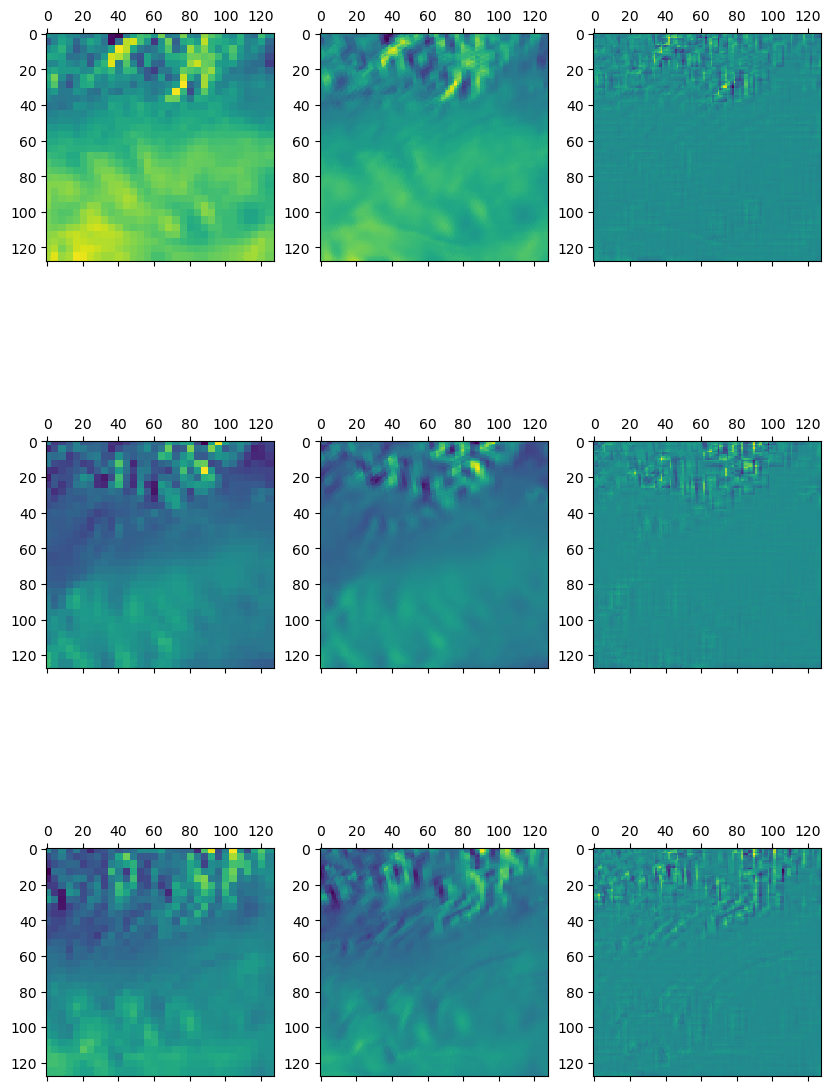

In [6]:
check_dir = os.path.join(working_dir,run_name)

check_dir_train = os.path.join(check_dir,'train')

files = glob.glob(check_dir_train+'/*.nc')

files_target = [file for file in files if '_t' in file]
files_train = [file for file in files if '_t' not in file]

example_file_index = 0
example_timesteps = [0,20,50]
var = 'vo'

train_coarse = xr.open_dataset(files_train[example_file_index])[var]
target_fine = xr.open_dataset(files_target[example_file_index])[var]

fig, ax = plt.subplots(len(example_timesteps), 3, figsize=(10,15))

for k,timestep in enumerate(example_timesteps):
    ax[k,0].matshow(train_coarse[timestep])
    ax[k,1].matshow(target_fine[timestep])
    ax[k,2].matshow(target_fine[timestep]-train_coarse[timestep])

In [4]:
train('/home/max/repos/climatereconstructionAI/exaocean/data_runs/cmip6_sample_downscaling/sr_test.inp')

* Number of GPUs:  0


lr = 2.0e-04:   0%|          | 0/100 [00:00<?, ?it/s]

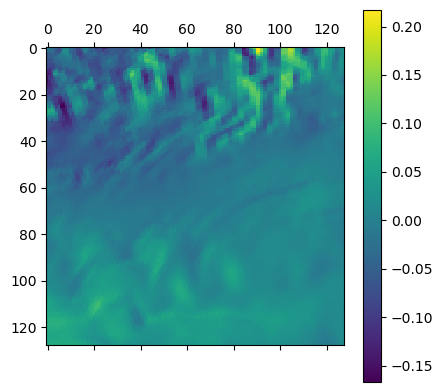

In [7]:
plt.matshow(target_fine[timestep])
plt.colorbar()

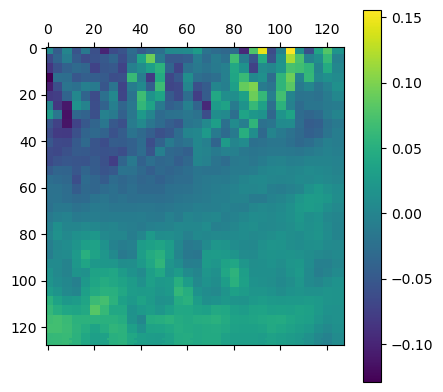

In [8]:
plt.matshow(train_coarse[timestep])
plt.colorbar()